In [20]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,  img_to_array
from tensorflow.keras import layers, models

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.6

In [21]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(train_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=batch_size,class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,target_size=(IMG_HEIGHT,IMG_WIDTH),batch_size=batch_size,class_mode='binary')

# test没有cat、dog的子目录，无法直接使用'flow_from_directory'
target_size=(IMG_HEIGHT,IMG_WIDTH)
test_images = []
for filename in os.listdir(test_dir):
  if filename.endswith('.jpg') or filename.endswith('.png'):
    img = load_img(os.path.join(test_dir,filename),target_size=target_size)
    img_array = img_to_array(img)
    test_images.append(img_array)

test_images = np.array(test_images)
test_label = np.zeros((test_images.shape[0],1))
num_images = len(test_images)

test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow(test_images, test_label, batch_size=batch_size)

print(f"Found {num_images} images belonging to 1 class.")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 class.


In [22]:
print(len(test_data_gen))

1


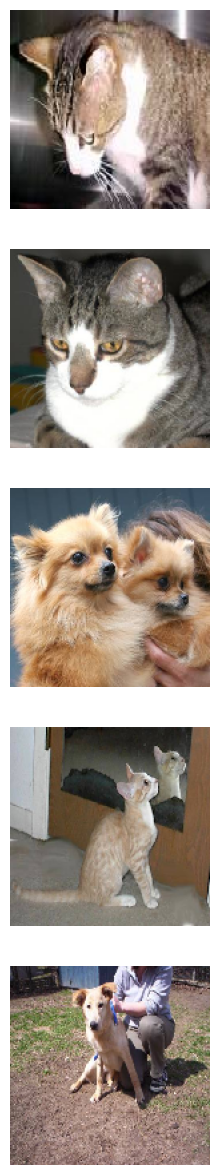

In [23]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [24]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255,
                      rotation_range=40,
                      width_shift_range=0.2,
                      height_shift_range=0.2,
                      shear_range=0.2,
                      zoom_range=0.2,
                      horizontal_flip=True,
                      fill_mode='nearest')

Found 2000 images belonging to 2 classes.


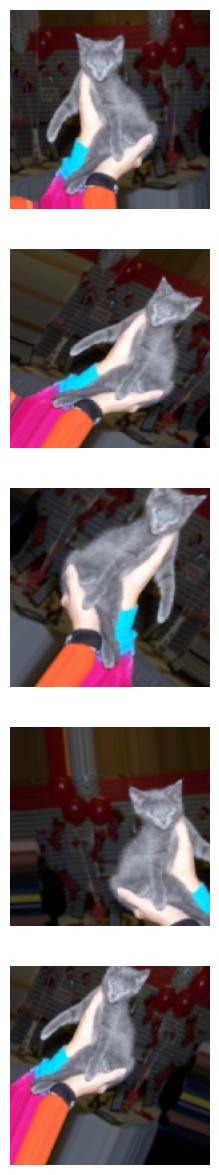

In [25]:
# 6
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                              batch_size=batch_size,
                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                              class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [26]:
# 7
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2))) # 使用 2x2 样本和 2 的步幅执行最大池化操作
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten()) # 展平数据
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # 输出层

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      42,467,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,487,745 (162.08 MB)

 Trainable params: 42,487,745 (162.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 8
# 训练模型
model.compile(optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'])

history = model.fit(train_data_gen, steps_per_epoch=len(train_data_gen), batch_size=batch_size, epochs=epochs,
          validation_data=val_data_gen, validation_steps=len(val_data_gen) )



Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.4925 - loss: 3.3660 - val_accuracy: 0.5340 - val_loss: 0.6819
Epoch 2/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 130s 7s/step - accuracy: 0.5175 - loss: 0.6851 - val_accuracy: 0.5770 - val_loss: 0.6773
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - accuracy: 0.5548 - loss: 0.6832 - val_accuracy: 0.5120 - val_loss: 0.6896
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.5329 - loss: 0.6863 - val_accuracy: 0.5660 - val_loss: 0.6770
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.5752 - loss: 0.6787 - val_accuracy: 0.6000 - val_loss: 0.6641
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 10


In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")